# Modeling

** WARNING :** To create an instance of `ConvNeXt`, you need to have nightly version of PyTorch

In [81]:
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
import torchvision

import numpy as np
import matplotlib.pyplot as plt

Here, we define most important constants, that define the process. Here we select which model and on what data we are going to train.

In [82]:
IMAGES_ROOT = "generated" # Path to the folder with all image datasets
INDICATOR = "roc" # one of  "ult", 'roc', "cci", "slow_d", "rsi", "aroon", "chande","apo"
MODEL_NAME = "resnet" # one of "alexnet", "vgg", "resnet", "densenet", "vit", "convnext"

DATA_PATH = f"{IMAGES_ROOT}/{INDICATOR}"

NUMBER_OF_EPOCHS = 1
BATCH_SIZE = 64
LEARNING_RATE = 1e-4

To do the training process using a GPU, your pc has to have CUDA support. Otherwise everything will be done on CPU. Trying to train models without GPU is highly unreasonable.

In [83]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In this cell we create data loaders from the directories, we have filled with images in the preprocessing step. We also define transforms, that will be applied to all the images. Resize is done for safety, but our images are already 224 by 224.

In [84]:
transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
])

train_dataset = datasets.ImageFolder(f"{DATA_PATH}/train", transform=transform)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = datasets.ImageFolder(f"{DATA_PATH}/val", transform=transform)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = datasets.ImageFolder(f"{DATA_PATH}/test", transform=transform)
test_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size=BATCH_SIZE, shuffle=True)

for X, y in val_loader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 3, 224, 224])
Shape of y:  torch.Size([64]) torch.int64


Let's see how one whole batch of images looks like

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


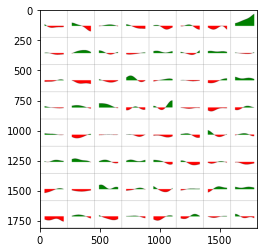

{'HOLD': 0, 'LONG': 1, 'SHORT': 2}


In [85]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(train_dataset.class_to_idx)

All models are different and require slight modifications to be finetuned on our data, so we added a selector function, that returns a fresh instance of one of the pretrained models with the classifier replaced by a layer, that suits our data.

In [93]:
def select_model(name, pretrained=True, feature_extractor=False):
    if name == "alexnet":
        model_ft = torchvision.models.alexnet(pretrained=pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        if feature_extractor:
            for param in model_ft.parameters():
                param.requires_grad = False
        model_ft.classifier[6] = nn.Linear(num_ftrs, 3)

    elif name == "vgg":
        model_ft = torchvision.models.vgg11_bn(pretrained=pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        if feature_extractor:
            for param in model_ft.parameters():
                param.requires_grad = False
        model_ft.classifier[6] = nn.Linear(num_ftrs,3)
    
    elif name == "resnet":
        model_ft = torchvision.models.resnet18(pretrained=pretrained)
        num_ftrs = model_ft.fc.in_features
        if feature_extractor:
            for param in model_ft.parameters():
                param.requires_grad = False
        model_ft.fc = nn.Linear(num_ftrs, 3)

    elif name == "densenet":
        model_ft = torchvision.models.densenet121(pretrained=pretrained)
        num_ftrs = model_ft.classifier.in_features
        if feature_extractor:
            for param in model_ft.parameters():
                param.requires_grad = False
        model_ft.classifier = nn.Linear(num_ftrs, 3)

    elif name == "vit":
        model_ft = torchvision.models.vit_b_16(pretrained=pretrained)
        if feature_extractor:
            for param in model_ft.parameters():
                param.requires_grad = False
        model_ft.heads.head = nn.Linear(in_features=768, out_features=3, bias=pretrained)


    # WARNING: AT THE MOMENT ConvNeXt requires nightly pytorch version
    elif name == "convnext":
        model_ft = torchvision.models.convnext_tiny(pretrained=pretrained)
        num_ftrs = model_ft.classifier[2].in_features
        if feature_extractor:
            for param in model_ft.parameters():
                param.requires_grad = False
        model_ft.classifier[2] = nn.Linear(num_ftrs, 3)
    
    else:
        raise Exception('Model name must be one of ["alexnet", "vgg", "resnet", "densenet", "vit", "convnext"]')

    return model_ft

## Training

To train a model, we will define a function, that will train our model for 1 whole epoch. Thankfully all the heavy lifting is done by PyTorch.

In [94]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Test function is more involved since it also calculates additional statistics. We keep track of the model's accuracy and a metric, that we have called "Trade accuracy". Trade accuracy is a precentage of made trades, that did not result in a significant loss for the trader, that is, the ones, where the model did not predict an opposite of the true label. This nunmber is supposed to be really high, and it is added be sure, that model behaves as expected.

In [90]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, correct_trades, trades_total = 0, 0, 0, 1
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct_trades += ((pred.argmax(1) == y) & (y != 0)).type(torch.float).sum().item()
            trades_total += ((pred.argmax(1) != 0) & (y != 0)).type(torch.float).sum().item()
            test_loss /= num_batches
    correct_trades /= trades_total 
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, Trade accuracy: {(100*correct_trades):>0.1f}%\n")
    return 100 * correct

Instantiate a model

In [ ]:
model_ft = select_model(MODEL_NAME)
model = model_ft.to(device)

Next, we create optimizer, scheduler and a criterion. As optimizer, we mostly used Adam. For ViT and ConvNeXt AdamW made more sense. Criterion is simply a cost function that PyTorch will use to create gradients.

We also create a learnig rate scheduler. Scheduler will multiply learning rate by `gamma` every `step_size` of epochs. This technique tends to improve preformance of the trained model.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [92]:
MODEL_PATH = "tmp_best.pth" # Where to save the best model's paramaters

And to combine it all, a standard PyTorch training loop. Each iteration of this loop is an epoch. After running through the whole dataset, it will evaluate model's perfomance on validation data and save the model if it outperformed the previos best.

In [79]:
best_score = -1
for t in range(NUMBER_OF_EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, criterion, optimizer)
    score = test(val_loader, model, criterion)
    if score > best_score:
        torch.save(model.state_dict(), MODEL_PATH)
        best_score = score
    scheduler.step()
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 2.4%, Avg loss: 0.133641, Trade accuracy: 48.1%

Done!


## Testing

The final step of the process. After training the model tuning it's hyperparameters, we can load the best performing set of parameters and find out how it performs on the test set.

In [80]:
model_to_test = select_model(MODEL_NAME).to(device)
model_to_test.load_state_dict(torch.load(MODEL_PATH))
test(test_loader, model_to_test, criterion)

Test Error: 
 Accuracy: 2.0%, Avg loss: 0.135347, Trade accuracy: 39.3%



1.9891500904159132